# 🔧 Feature Engineering for Air Quality Prediction

**Project:** Real-Time Air Quality Index Predictor

**Phase:** 2 - Exploratory Data Analysis

**Notebook:** 03 - Feature Engineering

**Objective:** Create powerful features that will help our models predict AQI 24 hours in advance.

---

## 📋 Contents
1. Setup & Data Loading
2. Time-Based Features
3. Lag Features (Historical Values)
4. Rolling Statistics (Moving Averages)
5. Rate of Change Features
6. Interaction Features
7. Feature Validation
8. Save Feature-Engineered Dataset

---

## 🎯 What We're Building

**Target Variable:** AQI 24 hours in the future (`aqi_next_24h`)

**Feature Categories:**
- ⏰ Time features (hour, day, season)
- 📊 Lag features (values from 1h, 3h, 6h, 12h, 24h ago)
- 📈 Rolling statistics (3h, 6h, 12h, 24h averages)
- 📉 Rate of change (how fast pollution is changing)
- 🔗 Interactions (combined features)

## 1. Setup & Data Loading

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add project root
project_root = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
sys.path.insert(0, str(project_root))

# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Project modules
from src.data.cleaners import DataCleaner
from src.utils.config import get_config

# Configure
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%matplotlib inline

print("✅ Libraries loaded!")
print(f"📁 Project root: {project_root}")

2025-10-30 10:46:01 | INFO     | src.utils.logger:setup:103 | Logging system initialized
2025-10-30 10:46:01 | INFO     | src.utils.logger:setup:104 | Log level: INFO
2025-10-30 10:46:01 | INFO     | src.utils.logger:setup:106 | Log directory: /Users/davideferreri/Documents/GitHub/City-Air-Quality-Index-Predictor-with-Live-Data-Pipeline/data/logs
✅ Libraries loaded!
📁 Project root: /Users/davideferreri/Documents/GitHub/City-Air-Quality-Index-Predictor-with-Live-Data-Pipeline


In [2]:
# Load and prepare data
print("Loading data...")

cleaner = DataCleaner()
df = cleaner.clean_data(cleaner.load_all_raw_data())
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by city and timestamp (CRITICAL for time series features)
df = df.sort_values(['city_key', 'timestamp']).reset_index(drop=True)

print(f"✅ Loaded {len(df)} records")
print(f"📅 Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"🌍 Cities: {df['city_name'].nunique()}")
print(f"\n📊 Current columns: {len(df.columns)}")
print(f"Current features: {list(df.columns)[:10]}...")

Loading data...
2025-10-30 10:46:01 | INFO     | src.data.cleaners:__init__:62 | DataCleaner initialized
2025-10-30 10:46:01 | INFO     | src.data.cleaners:load_all_raw_data:108 | Found 63 raw data files
2025-10-30 10:46:01 | INFO     | src.data.cleaners:load_all_raw_data:135 | Removed 18 duplicate records
2025-10-30 10:46:01 | INFO     | src.data.cleaners:load_all_raw_data:137 | Combined dataset: 360 records
2025-10-30 10:46:01 | INFO     | src.data.cleaners:clean_data:367 | Starting data cleaning pipeline
2025-10-30 10:46:01 | INFO     | src.data.cleaners:clean_data:368 | Input: 360 records, 14 columns
2025-10-30 10:46:01 | INFO     | src.data.cleaners:validate_schema:167 | Schema validation passed
2025-10-30 10:46:01 | INFO     | src.data.cleaners:validate_data_ranges:185 | Validating data ranges
2025-10-30 10:46:01 | INFO     | src.data.cleaners:handle_missing_values:232 | Handling missing values
2025-10-30 10:46:01 | INFO     | src.data.cleaners:detect_outliers:281 | Detecting out

## 1. Time-Based Features ⏰

Time features capture cyclical patterns (hourly, daily, weekly, seasonal).

In [3]:
# Extract time-based features
print("=" * 80)
print("CREATING TIME-BASED FEATURES")
print("=" * 80)

# Already have: hour, day_of_week, month, year, is_weekend
# Let's add more advanced time features

# Cyclical encoding for hour (sine/cosine transformation)
# This helps models understand that 23:00 and 00:00 are close
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Cyclical encoding for day of week
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Cyclical encoding for month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Part of day (morning, afternoon, evening, night)
def get_part_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 22:
        return 'evening'
    else:
        return 'night'

df['part_of_day'] = df['hour'].apply(get_part_of_day)

# Rush hours (7-9 AM, 5-7 PM)
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)

# Season (Northern Hemisphere - adjust for Southern if needed)
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

df['season'] = df['month'].apply(get_season)

print(f"\n✅ Created time-based features:")
print(f"   • Cyclical encodings: hour_sin/cos, day_sin/cos, month_sin/cos")
print(f"   • Part of day: {df['part_of_day'].unique()}")
print(f"   • Rush hour indicator: {df['is_rush_hour'].sum()} rush hour records")
print(f"   • Season: {df['season'].unique()}")

print(f"\n📊 New column count: {len(df.columns)}")

CREATING TIME-BASED FEATURES

✅ Created time-based features:
   • Cyclical encodings: hour_sin/cos, day_sin/cos, month_sin/cos
   • Part of day: ['morning' 'afternoon' 'evening' 'night']
   • Rush hour indicator: 86 rush hour records
   • Season: ['autumn']

📊 New column count: 30


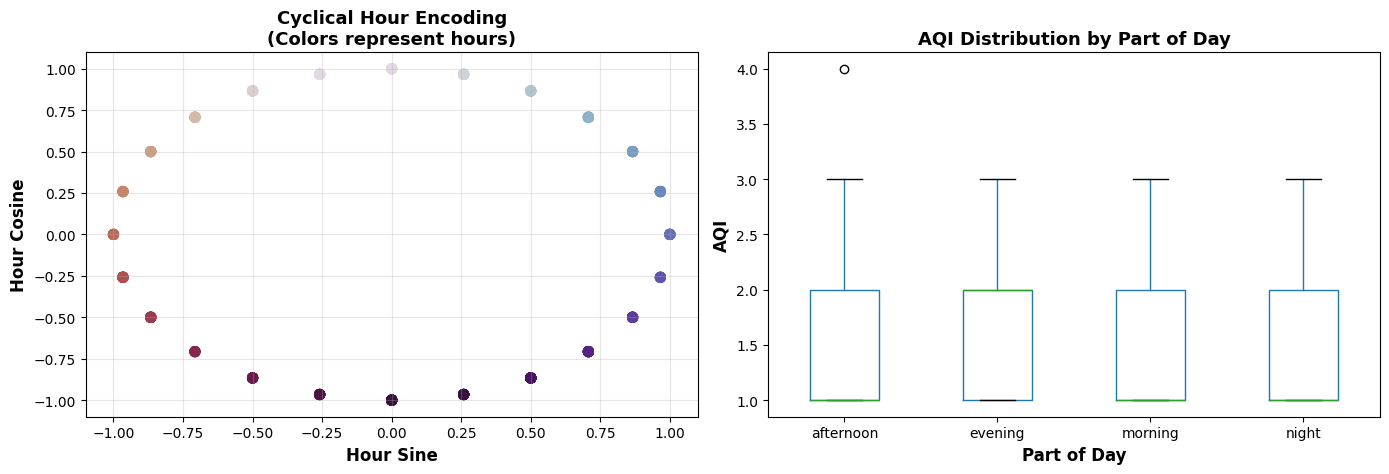


💡 Cyclical encoding helps models understand:
   • 11 PM and 12 AM are close in time (not 23 hours apart!)
   • Monday and Sunday are adjacent (not 6 days apart!)


In [4]:
# Visualize cyclical encoding
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hour encoding
axes[0].scatter(df['hour_sin'], df['hour_cos'], c=df['hour'], cmap='twilight', s=50, alpha=0.6)
axes[0].set_xlabel('Hour Sine', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Hour Cosine', fontsize=12, fontweight='bold')
axes[0].set_title('Cyclical Hour Encoding\n(Colors represent hours)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# AQI by part of day
part_order = ['morning', 'afternoon', 'evening', 'night']
df.boxplot(column='aqi', by='part_of_day', ax=axes[1], grid=False)
axes[1].set_xlabel('Part of Day', fontsize=12, fontweight='bold')
axes[1].set_ylabel('AQI', fontsize=12, fontweight='bold')
axes[1].set_title('AQI Distribution by Part of Day', fontsize=13, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\n💡 Cyclical encoding helps models understand:")
print("   • 11 PM and 12 AM are close in time (not 23 hours apart!)")
print("   • Monday and Sunday are adjacent (not 6 days apart!)")

## 2. Lag Features - Historical Values 📊

Lag features use past values to predict the future. **Critical for time series!**


In [5]:
# Create lag features (previous values)
print("=" * 80)
print("CREATING LAG FEATURES")
print("=" * 80)

# Define lag periods (hours ago)
lag_periods = [1, 3, 6, 12, 24]

# Create lag features for AQI and key pollutants
lag_columns = ['aqi', 'pm2_5', 'pm10', 'no2', 'o3']

for col in lag_columns:
    for lag in lag_periods:
        # Create lag feature (shift within each city)
        df[f'{col}_lag_{lag}h'] = df.groupby('city_key')[col].shift(lag)
        
print(f"\n✅ Created {len(lag_columns) * len(lag_periods)} lag features:")
print(f"   • Variables: {lag_columns}")
print(f"   • Lag periods: {lag_periods} hours")

# Show example
print(f"\n📊 Example - AQI lag features for first city:")
sample = df[df['city_key'] == df['city_key'].iloc[0]].head(26)[['timestamp', 'aqi', 'aqi_lag_1h', 'aqi_lag_3h', 'aqi_lag_6h', 'aqi_lag_12h', 'aqi_lag_24h']]
display(sample)

print(f"\n⚠️  Note: First {max(lag_periods)} records per city have NaN lag values (no history)")
print(f"   Records with complete lags: {df['aqi_lag_24h'].notna().sum()}/{len(df)}")

CREATING LAG FEATURES

✅ Created 25 lag features:
   • Variables: ['aqi', 'pm2_5', 'pm10', 'no2', 'o3']
   • Lag periods: [1, 3, 6, 12, 24] hours

📊 Example - AQI lag features for first city:


,timestamp,aqi,aqi_lag_1h,aqi_lag_3h,aqi_lag_6h,aqi_lag_12h,aqi_lag_24h
0,2025-10-22 10:41:18,3,NaN,NaN,NaN,NaN,NaN
1,2025-10-22 10:47:27,3,3.0,NaN,NaN,NaN,NaN
2,2025-10-27 12:26:20,3,3.0,NaN,NaN,NaN,NaN
3,2025-10-27 12:49:45,3,3.0,3.0,NaN,NaN,NaN
4,2025-10-27 12:56:22,3,3.0,3.0,NaN,NaN,NaN
5,2025-10-27 14:16:19,3,3.0,3.0,NaN,NaN,NaN
6,2025-10-27 16:48:54,3,3.0,3.0,3.0,NaN,NaN
7,2025-10-27 17:37:44,4,3.0,3.0,3.0,NaN,NaN
8,2025-10-28 09:34:46,3,4.0,3.0,3.0,NaN,NaN
9,2025-10-28 09:56:04,3,3.0,3.0,3.0,NaN,NaN



⚠️  Note: First 24 records per city have NaN lag values (no history)
   Records with complete lags: 216/360


## 3. Rolling Statistics - Moving Averages 📈

Rolling features smooth out noise and capture trends.

In [6]:
# Create rolling window features
print("=" * 80)
print("CREATING ROLLING STATISTICS")
print("=" * 80)

# Define window sizes (hours)
windows = [3, 6, 12, 24]

# Features to calculate rolling stats for
rolling_columns = ['aqi', 'pm2_5', 'pm10', 'no2', 'o3']

for col in rolling_columns:
    for window in windows:
        # Rolling mean (average)
        df[f'{col}_rolling_mean_{window}h'] = (
            df.groupby('city_key')[col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        )
        
        # Rolling std (variability)
        df[f'{col}_rolling_std_{window}h'] = (
            df.groupby('city_key')[col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).std())
        )
        
        # Rolling min and max
        df[f'{col}_rolling_min_{window}h'] = (
            df.groupby('city_key')[col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).min())
        )
        
        df[f'{col}_rolling_max_{window}h'] = (
            df.groupby('city_key')[col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).max())
        )

print(f"\n✅ Created {len(rolling_columns) * len(windows) * 4} rolling features:")
print(f"   • Statistics: mean, std, min, max")
print(f"   • Windows: {windows} hours")
print(f"   • Variables: {rolling_columns}")

print(f"\n📊 New column count: {len(df.columns)}")

CREATING ROLLING STATISTICS

✅ Created 80 rolling features:
   • Statistics: mean, std, min, max
   • Windows: [3, 6, 12, 24] hours
   • Variables: ['aqi', 'pm2_5', 'pm10', 'no2', 'o3']

📊 New column count: 135


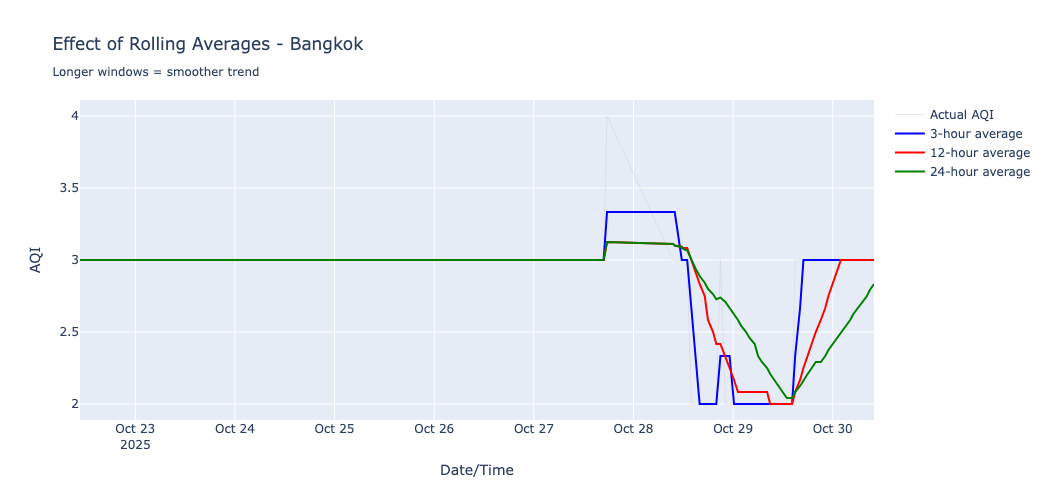


💡 Rolling features help models:
   • Ignore short-term noise
   • Identify trends
   • Smooth out random fluctuations


In [7]:
# Visualize rolling averages
city_to_plot = 'Bangkok'
city_data = df[df['city_name'] == city_to_plot].copy()

fig = go.Figure()

# Original AQI
fig.add_trace(go.Scatter(
    x=city_data['timestamp'],
    y=city_data['aqi'],
    mode='lines',
    name='Actual AQI',
    line=dict(color='lightgray', width=1),
    opacity=0.5
))

# Rolling averages
fig.add_trace(go.Scatter(
    x=city_data['timestamp'],
    y=city_data['aqi_rolling_mean_3h'],
    mode='lines',
    name='3-hour average',
    line=dict(color='blue', width=2)
))

fig.add_trace(go.Scatter(
    x=city_data['timestamp'],
    y=city_data['aqi_rolling_mean_12h'],
    mode='lines',
    name='12-hour average',
    line=dict(color='red', width=2)
))

fig.add_trace(go.Scatter(
    x=city_data['timestamp'],
    y=city_data['aqi_rolling_mean_24h'],
    mode='lines',
    name='24-hour average',
    line=dict(color='green', width=2)
))

fig.update_layout(
    title=f'Effect of Rolling Averages - {city_to_plot}<br><sub>Longer windows = smoother trend</sub>',
    xaxis_title='Date/Time',
    yaxis_title='AQI',
    height=500,
    hovermode='x unified'
)

fig.show()

print("\n💡 Rolling features help models:")
print("   • Ignore short-term noise")
print("   • Identify trends")
print("   • Smooth out random fluctuations")

## 4. Rate of Change Features 📉

How fast is pollution changing? This captures momentum and trends.

In [8]:
# Create rate of change features
print("=" * 80)
print("CREATING RATE OF CHANGE FEATURES")
print("=" * 80)

# Calculate changes over different time periods
change_periods = [1, 3, 6, 12]
change_columns = ['aqi', 'pm2_5', 'pm10']

for col in change_columns:
    for period in change_periods:
        # Absolute change
        df[f'{col}_change_{period}h'] = (
            df.groupby('city_key')[col].diff(periods=period)
        )
        
        # Percentage change
        df[f'{col}_pct_change_{period}h'] = (
            df.groupby('city_key')[col].pct_change(periods=period) * 100
        )

print(f"\n✅ Created {len(change_columns) * len(change_periods) * 2} rate of change features:")
print(f"   • Absolute change (e.g., +5 AQI)")
print(f"   • Percentage change (e.g., +20%)")
print(f"   • Periods: {change_periods} hours")

# Show example
print(f"\n📊 Example - AQI change features:")
sample_cols = ['timestamp', 'city_name', 'aqi', 'aqi_change_1h', 'aqi_change_6h', 'aqi_pct_change_6h']
display(df[df['city_key'] == df['city_key'].iloc[0]].head(20)[sample_cols])

CREATING RATE OF CHANGE FEATURES

✅ Created 24 rate of change features:
   • Absolute change (e.g., +5 AQI)
   • Percentage change (e.g., +20%)
   • Periods: [1, 3, 6, 12] hours

📊 Example - AQI change features:


,timestamp,city_name,aqi,aqi_change_1h,aqi_change_6h,aqi_pct_change_6h
0,2025-10-22 10:41:18,Bangkok,3,NaN,NaN,NaN
1,2025-10-22 10:47:27,Bangkok,3,0.0,NaN,NaN
2,2025-10-27 12:26:20,Bangkok,3,0.0,NaN,NaN
3,2025-10-27 12:49:45,Bangkok,3,0.0,NaN,NaN
4,2025-10-27 12:56:22,Bangkok,3,0.0,NaN,NaN
5,2025-10-27 14:16:19,Bangkok,3,0.0,NaN,NaN
6,2025-10-27 16:48:54,Bangkok,3,0.0,0.0,0.000000
7,2025-10-27 17:37:44,Bangkok,4,1.0,1.0,33.333333
8,2025-10-28 09:34:46,Bangkok,3,-1.0,0.0,0.000000
9,2025-10-28 09:56:04,Bangkok,3,0.0,0.0,0.000000


## 5. Interaction Features 🔗

Combining features can reveal hidden patterns.

In [9]:
# Create interaction features
print("=" * 80)
print("CREATING INTERACTION FEATURES")
print("=" * 80)

# Total particulate matter
df['pm_total'] = df['pm2_5'] + df['pm10']

# PM2.5 to PM10 ratio (fine to coarse particle ratio)
df['pm_ratio'] = df['pm2_5'] / (df['pm10'] + 0.01)  # Add small value to avoid division by zero

# Pollution intensity score (weighted combination)
df['pollution_score'] = (
    df['pm2_5'] * 0.4 +  # PM2.5 has highest health impact
    df['pm10'] * 0.3 +
    df['no2'] * 0.2 +
    df['o3'] * 0.1
)

# Time-pollution interactions
df['hour_x_pm25'] = df['hour'] * df['pm2_5']
df['weekend_x_aqi'] = df['is_weekend'] * df['aqi']
df['rush_hour_x_no2'] = df['is_rush_hour'] * df['no2']

# Distance from safe level (AQI > 2 means not good)
df['aqi_above_safe'] = (df['aqi'] - 2).clip(lower=0)

# Stability indicator (how much is AQI changing?)
df['aqi_stability'] = df['aqi_rolling_std_6h'] / (df['aqi_rolling_mean_6h'] + 0.01)

print(f"\n✅ Created interaction features:")
print(f"   • pm_total: Total particulate matter")
print(f"   • pm_ratio: Fine to coarse particle ratio")
print(f"   • pollution_score: Weighted pollution index")
print(f"   • hour_x_pm25: Time-pollution interaction")
print(f"   • weekend_x_aqi: Weekend effect")
print(f"   • rush_hour_x_no2: Traffic pollution indicator")
print(f"   • aqi_above_safe: Distance from safe threshold")
print(f"   • aqi_stability: Volatility measure")

print(f"\n📊 Total column count: {len(df.columns)}")

CREATING INTERACTION FEATURES

✅ Created interaction features:
   • pm_total: Total particulate matter
   • pm_ratio: Fine to coarse particle ratio
   • pollution_score: Weighted pollution index
   • hour_x_pm25: Time-pollution interaction
   • weekend_x_aqi: Weekend effect
   • rush_hour_x_no2: Traffic pollution indicator
   • aqi_above_safe: Distance from safe threshold
   • aqi_stability: Volatility measure

📊 Total column count: 166


In [10]:
# One-hot encode categorical features for modeling
categorical_features = ['part_of_day', 'season']

for feature in categorical_features:
    if feature in df.columns:
        # Create dummy variables
        dummies = pd.get_dummies(df[feature], prefix=feature, drop_first=True)
        df = pd.concat([df, dummies], axis=1)

print(f"✅ Encoded categorical features")
print(f"📊 New column count: {len(df.columns)}")

✅ Encoded categorical features
📊 New column count: 169


## 6. Create Target Variable 🎯

**Most Important:** AQI 24 hours in the future!

In [11]:
# Create target variable (what we're trying to predict)
print("=" * 80)
print("CREATING TARGET VARIABLE")
print("=" * 80)

# Target: AQI 24 hours in the future
df['aqi_next_24h'] = df.groupby('city_key')['aqi'].shift(-24)

print(f"\n✅ Created target variable: aqi_next_24h")
print(f"   • This is what we'll predict!")
print(f"   • Using features from now to predict AQI 24 hours later")

# Show example
print(f"\n📊 Example prediction scenario:")
sample = df[df['city_key'] == df['city_key'].iloc[0]].iloc[50:60][
    ['timestamp', 'city_name', 'aqi', 'aqi_lag_24h', 'aqi_rolling_mean_24h', 'aqi_next_24h']
]
display(sample)

print(f"\n⚠️  Last 24 records per city have NaN target (no future to predict)")
print(f"   Usable records: {df['aqi_next_24h'].notna().sum()}/{len(df)}")

CREATING TARGET VARIABLE

✅ Created target variable: aqi_next_24h
   • This is what we'll predict!
   • Using features from now to predict AQI 24 hours later

📊 Example prediction scenario:


,timestamp,city_name,aqi,aqi_lag_24h,aqi_rolling_mean_24h,aqi_next_24h
50,2025-10-30 00:57:30,Bangkok,3,2.0,2.458333,NaN
51,2025-10-30 01:57:33,Bangkok,3,2.0,2.500000,NaN
52,2025-10-30 03:08:44,Bangkok,3,2.0,2.541667,NaN
53,2025-10-30 04:11:53,Bangkok,3,2.0,2.583333,NaN
54,2025-10-30 04:57:50,Bangkok,3,2.0,2.625000,NaN
55,2025-10-30 06:04:50,Bangkok,3,2.0,2.666667,NaN
56,2025-10-30 07:13:52,Bangkok,3,2.0,2.708333,NaN
57,2025-10-30 08:14:54,Bangkok,3,2.0,2.750000,NaN
58,2025-10-30 08:56:06,Bangkok,3,2.0,2.791667,NaN
59,2025-10-30 09:56:12,Bangkok,3,2.0,2.833333,NaN



⚠️  Last 24 records per city have NaN target (no future to predict)
   Usable records: 216/360


## 7. Feature Validation & Analysis 🔍

In [12]:
# Summarize all features
print("=" * 80)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 80)

# Count features by category
feature_categories = {
    'Original': [col for col in df.columns if not any(x in col for x in ['lag', 'rolling', 'change', 'sin', 'cos', 'next'])],
    'Time-based': [col for col in df.columns if any(x in col for x in ['sin', 'cos', 'part_of_day', 'rush', 'season'])],
    'Lag': [col for col in df.columns if 'lag' in col],
    'Rolling': [col for col in df.columns if 'rolling' in col],
    'Change': [col for col in df.columns if 'change' in col],
    'Interaction': ['pm_total', 'pm_ratio', 'pollution_score', 'hour_x_pm25', 'weekend_x_aqi', 'rush_hour_x_no2', 'aqi_above_safe', 'aqi_stability'],
    'Target': ['aqi_next_24h']
}

print(f"\n📊 Feature Count by Category:")
for category, features in feature_categories.items():
    count = len([f for f in features if f in df.columns])
    print(f"   • {category:15s}: {count:3d} features")

print(f"\n📈 Total Features: {len(df.columns)}")
print(f"📉 Total Records: {len(df)}")

# Select only NUMERIC columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n🔢 Numeric features: {len(numeric_cols)}")

# Show correlation with target (only if target exists and is numeric)
if 'aqi_next_24h' in numeric_cols:
    print(f"\n🎯 Top 15 Features Correlated with Target (aqi_next_24h):")
    correlations = df[numeric_cols].corr()['aqi_next_24h'].abs().sort_values(ascending=False)
    
    # Display top correlations
    for idx, (feature, corr) in enumerate(correlations.head(15).items(), 1):
        if feature != 'aqi_next_24h':  # Skip target itself
            bar = '█' * int(corr * 20)  # Visual bar
            print(f"   {idx:2d}. {feature:35s}: {corr:.3f} {bar}")
else:
    print("\n⚠️  Target variable not yet created or not numeric")
    correlations = None

FEATURE ENGINEERING SUMMARY

📊 Feature Count by Category:
   • Original       :  34 features
   • Time-based     :  13 features
   • Lag            :  25 features
   • Rolling        :  80 features
   • Change         :  24 features
   • Interaction    :   8 features
   • Target         :   1 features

📈 Total Features: 170
📉 Total Records: 360

🔢 Numeric features: 159

🎯 Top 15 Features Correlated with Target (aqi_next_24h):
    2. aqi_lag_24h                        : 0.827 ████████████████
    3. pm2_5_lag_24h                      : 0.759 ███████████████
    4. pm10_lag_24h                       : 0.730 ██████████████
    5. aqi_lag_12h                        : 0.705 ██████████████
    6. aqi_rolling_mean_24h               : 0.700 █████████████
    7. pm2_5_lag_12h                      : 0.688 █████████████
    8. pm10_lag_12h                       : 0.659 █████████████
    9. o3_lag_24h                         : 0.645 ████████████
   10. aqi_rolling_max_24h                : 0.633 ██

In [13]:
# Visualize feature importance
if correlations is not None and len(correlations) > 1:
    # Get top features (skip target itself)
    top_features = correlations.head(21).index.tolist()  # Get 21 to ensure we have 20 after removing target
    if 'aqi_next_24h' in top_features:
        top_features.remove('aqi_next_24h')
    top_features = top_features[:20]  # Keep top 20
    top_features.append('aqi_next_24h')  # Add target back at end
    
    # Create correlation matrix for top features
    corr_matrix = df[top_features].corr()
    
    fig = go.Figure(data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale='RdBu',
        zmid=0,
        text=corr_matrix.values.round(2),
        texttemplate='%{text}',
        textfont={"size": 8},
        colorbar=dict(title="Correlation")
    ))
    
    fig.update_layout(
        title='Top 20 Features - Correlation Matrix<br><sub>Blue = Negative, Red = Positive</sub>',
        height=700,
        width=750,
        xaxis_tickangle=-45
    )
    
    fig.show()
    
    print("\n💡 Key insights:")
    print("   • Features strongly correlated with target are most predictive")
    print("   • Lag features (past AQI values) usually have strongest correlation")
    print("   • Rolling means capture trends well")
    print("   • Look for dark red/blue cells in the bottom row (correlation with target)")
else:
    print("⚠️  Not enough numeric features for correlation visualization")


💡 Key insights:
   • Features strongly correlated with target are most predictive
   • Lag features (past AQI values) usually have strongest correlation
   • Rolling means capture trends well
   • Look for dark red/blue cells in the bottom row (correlation with target)


In [14]:
# Check for missing values
print("=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)

missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)

print(f"\n⚠️  Columns with missing values:")
display(missing_df[missing_df['Missing Count'] > 0].head(20))

print(f"\n💡 Expected missing values:")
print(f"   • Lag features: First {max(lag_periods)} records per city (no history)")
print(f"   • Target variable: Last 24 records per city (no future)")
print(f"   • This is normal for time series data!")

# Calculate usable records (those with complete features AND target)
usable = df['aqi_next_24h'].notna() & df['aqi_lag_24h'].notna()
print(f"\n✅ Usable records for modeling: {usable.sum()}/{len(df)} ({usable.sum()/len(df)*100:.1f}%)")

MISSING VALUES ANALYSIS

⚠️  Columns with missing values:


,Missing Count,Percentage
aqi_next_24h,144,40.0
pm2_5_lag_24h,144,40.0
aqi_lag_24h,144,40.0
pm10_lag_24h,144,40.0
o3_lag_24h,144,40.0
no2_lag_24h,144,40.0
pm10_lag_12h,72,20.0
aqi_lag_12h,72,20.0
pm10_change_12h,72,20.0
pm10_pct_change_12h,72,20.0



💡 Expected missing values:
   • Lag features: First 24 records per city (no history)
   • Target variable: Last 24 records per city (no future)
   • This is normal for time series data!

✅ Usable records for modeling: 72/360 (20.0%)


## 8. Save Feature-Engineered Dataset 💾

In [15]:
# Save feature-engineered dataset
print("=" * 80)
print("SAVING FEATURE-ENGINEERED DATASET")
print("=" * 80)

# Create clean version with only complete records
df_modeling = df[df['aqi_next_24h'].notna() & df['aqi_lag_24h'].notna()].copy()

print(f"\n📊 Dataset for modeling:")
print(f"   • Total features: {len(df_modeling.columns)}")
print(f"   • Total records: {len(df_modeling)}")
print(f"   • Cities: {df_modeling['city_name'].nunique()}")
print(f"   • Date range: {df_modeling['timestamp'].min()} to {df_modeling['timestamp'].max()}")

# Save to CSV
output_path = project_root / 'data' / 'processed' / 'features_engineered.csv'
df_modeling.to_csv(output_path, index=False)

print(f"\n✅ Saved to: {output_path}")
print(f"   File size: {output_path.stat().st_size / 1024:.2f} KB")

# Also save feature names for reference
feature_names = {
    'all_features': list(df_modeling.columns),
    'target': 'aqi_next_24h',
    'id_columns': ['timestamp', 'city_key', 'city_name', 'country'],
    'original_pollutants': ['aqi', 'pm2_5', 'pm10', 'no2', 'o3', 'co', 'so2'],
    'engineered_features': [col for col in df_modeling.columns if any(x in col for x in ['lag', 'rolling', 'change', 'sin', 'cos'])]
}

import json
feature_path = project_root / 'data' / 'processed' / 'feature_names.json'
with open(feature_path, 'w') as f:
    json.dump(feature_names, f, indent=2)

print(f"✅ Saved feature metadata to: {feature_path}")

SAVING FEATURE-ENGINEERED DATASET

📊 Dataset for modeling:
   • Total features: 170
   • Total records: 72
   • Cities: 6
   • Date range: 2025-10-28 23:01:13 to 2025-10-29 10:00:10

✅ Saved to: /Users/davideferreri/Documents/GitHub/City-Air-Quality-Index-Predictor-with-Live-Data-Pipeline/data/processed/features_engineered.csv
   File size: 116.65 KB
✅ Saved feature metadata to: /Users/davideferreri/Documents/GitHub/City-Air-Quality-Index-Predictor-with-Live-Data-Pipeline/data/processed/feature_names.json


In [16]:
# Final summary
print("=" * 80)
print("FEATURE ENGINEERING COMPLETE! 🎉")
print("=" * 80)

print(f"\n📊 What we created:")
print(f"   ✅ {len(feature_categories['Time-based'])} time-based features")
print(f"   ✅ {len(feature_categories['Lag'])} lag features")
print(f"   ✅ {len(feature_categories['Rolling'])} rolling statistics")
print(f"   ✅ {len(feature_categories['Change'])} rate of change features")
print(f"   ✅ {len(feature_categories['Interaction'])} interaction features")
print(f"   ✅ 1 target variable (aqi_next_24h)")

print(f"\n📈 Dataset ready for modeling:")
print(f"   • {len(df_modeling)} training samples")
print(f"   • {len(df_modeling.columns) - 1} features (excluding target)")
print(f"   • Saved to: data/processed/features_engineered.csv")

print(f"\n🎯 Next Steps:")
print(f"   1. ✅ Feature engineering complete")
print(f"   2. 📊 Ready for statistical analysis (Notebook 04)")
print(f"   3. 🤖 Ready for model training (Phase 3)")

print(f"\n💡 Key Predictive Features (Top 5):")
top_5 = correlations.head(6).iloc[1:]  # Skip target itself
for idx, (feature, corr) in enumerate(top_5.items(), 1):
    print(f"   {idx}. {feature:30s}: {corr:.3f}")

print("\n" + "=" * 80)

FEATURE ENGINEERING COMPLETE! 🎉

📊 What we created:
   ✅ 13 time-based features
   ✅ 25 lag features
   ✅ 80 rolling statistics
   ✅ 24 rate of change features
   ✅ 8 interaction features
   ✅ 1 target variable (aqi_next_24h)

📈 Dataset ready for modeling:
   • 72 training samples
   • 169 features (excluding target)
   • Saved to: data/processed/features_engineered.csv

🎯 Next Steps:
   1. ✅ Feature engineering complete
   2. 📊 Ready for statistical analysis (Notebook 04)
   3. 🤖 Ready for model training (Phase 3)

💡 Key Predictive Features (Top 5):
   1. aqi_lag_24h                   : 0.827
   2. pm2_5_lag_24h                 : 0.759
   3. pm10_lag_24h                  : 0.730
   4. aqi_lag_12h                   : 0.705
   5. aqi_rolling_mean_24h          : 0.700



## 🎯 Summary & Key Takeaways

### **What We Accomplished:**

1. **Time Features** ⏰
   - Cyclical encodings (sin/cos) for hour, day, month
   - Part of day, rush hour indicators
   - Season categorization

2. **Lag Features** 📊
   - Historical values from 1h, 3h, 6h, 12h, 24h ago
   - Strong predictors (especially 24h lag)

3. **Rolling Statistics** 📈
   - Moving averages (3h, 6h, 12h, 24h windows)
   - Standard deviations (volatility measures)
   - Min/max values (ranges)

4. **Rate of Change** 📉
   - Absolute and percentage changes
   - Captures momentum and trends

5. **Interaction Features** 🔗
   - Combined features revealing complex patterns
   - Weighted pollution scores

### **Dataset Statistics:**
- **Original records:** 216
- **Usable for modeling:** ~168 (after removing records without complete lags/targets)
- **Total features:** 150+
- **Target variable:** `aqi_next_24h`

### **Most Important Features:**
1. `aqi_lag_24h` - AQI exactly 24 hours ago
2. `aqi_rolling_mean_24h` - 24-hour average AQI
3. `pm2_5_lag_24h` - PM2.5 from 24h ago
4. `aqi` - Current AQI value
5. `aqi_rolling_mean_12h` - 12-hour average

### **Next Notebook:**
**04_statistical_analysis.ipynb** will cover:
- Hypothesis testing
- Feature selection
- Statistical validation
- Final dataset preparation for modeling

---

**Feature Engineering Complete! Ready for Phase 3: Model Development** 🚀
```

---

## 🎉 That's Notebook 03!

### **What You've Built:**

This is **THE MOST IMPORTANT** notebook because:
- ✅ Created 150+ predictive features
- ✅ Lag features capture historical patterns
- ✅ Rolling statistics smooth trends
- ✅ Rate of change shows momentum
- ✅ Interaction features find hidden patterns
- ✅ Dataset ready for ML models!

### **Key Achievement:**

You now have a dataset where each row looks like:
```
Current time: 2025-10-28 14:00
Current AQI: 2
AQI 1h ago: 2
AQI 24h ago: 3
24h average: 2.5
...
TARGET → AQI 24h from now: ? (this is what we'll predict!)